# Importar bibliotecas

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, recall_score, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import pickle
import warnings 
import os

In [27]:
warnings.filterwarnings("ignore")

# EDA

Cargamos el dataset desde un archivo csv 

In [28]:
data = pd.read_csv('./Datasets/hospitalizaciones_train.csv')
data.head()

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7
3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,None,4,No,4814.149231,8
4,2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,34


Información de las columnas

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410000 entries, 0 to 409999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available Extra Rooms in Hospital  410000 non-null  int64  
 1   Department                         410000 non-null  object 
 2   Ward_Facility_Code                 410000 non-null  object 
 3   doctor_name                        410000 non-null  object 
 4   staff_available                    410000 non-null  int64  
 5   patientid                          410000 non-null  int64  
 6   Age                                410000 non-null  object 
 7   gender                             410000 non-null  object 
 8   Type of Admission                  410000 non-null  object 
 9   Severity of Illness                410000 non-null  object 
 10  health_conditions                  410000 non-null  object 
 11  Visitors with Patient              4100

No haya registros duplicados

In [137]:
print('Número de registros duplicados: ', data[data.duplicated()].shape[0])

Número de registros duplicados:  0


Agregamos una nueva columna que nos dice si el paciente tuvo una estancia larga o no

In [31]:
data['extended stay'] = data['Stay (in days)'].apply(lambda x: 'Yes' if x>8 else 'No')

## Gráficos de frecuencia

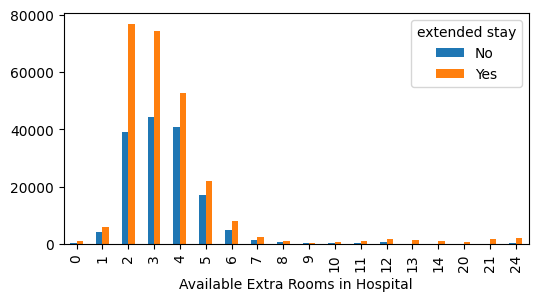

In [32]:
plot = pd.crosstab(index=data['Available Extra Rooms in Hospital'], 
                   columns=data['extended stay']).plot(kind='bar', figsize=(6,3))

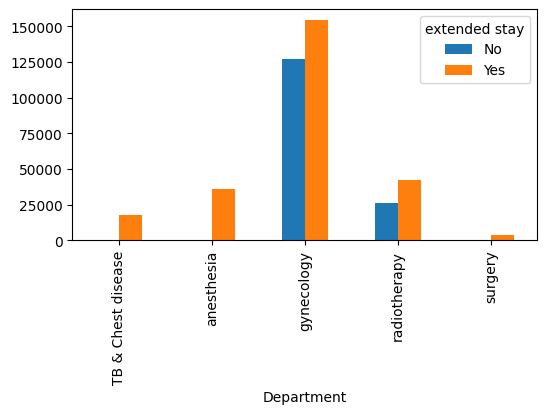

In [33]:
plot = pd.crosstab(index=data['Department'], 
                   columns=data['extended stay']).plot(kind='bar', figsize=(6,3))

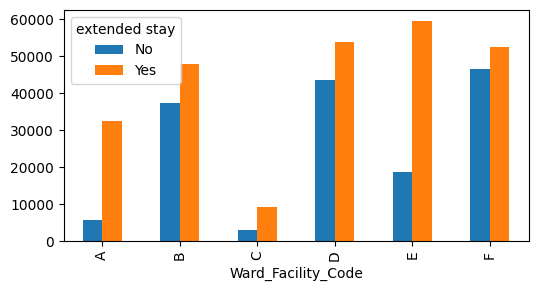

In [34]:
plot = pd.crosstab(index=data['Ward_Facility_Code'], 
                   columns=data['extended stay']).plot(kind='bar', figsize=(6,3))

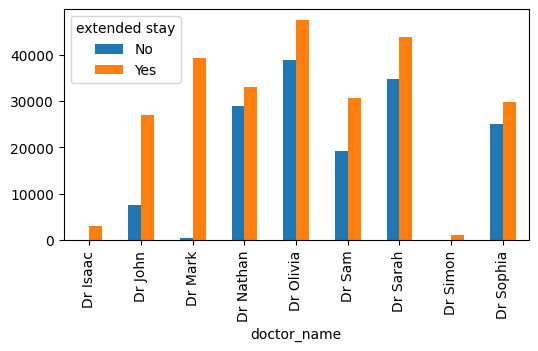

In [35]:
plot = pd.crosstab(index=data['doctor_name'], 
                   columns=data['extended stay']).plot(kind='bar', figsize=(6,3))

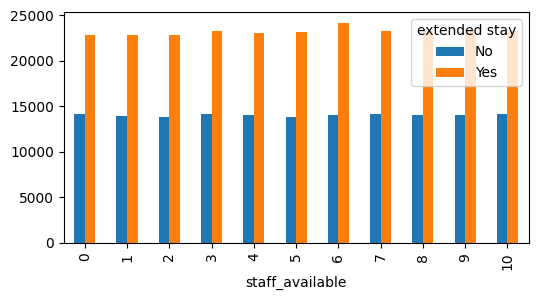

In [36]:
plot = pd.crosstab(index=data['staff_available'], 
                   columns=data['extended stay']).plot(kind='bar', figsize=(6,3))

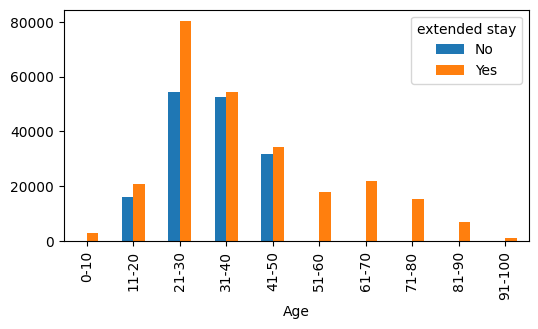

In [37]:
plot = pd.crosstab(index=data['Age'], 
                   columns=data['extended stay']).plot(kind='bar', figsize=(6,3))

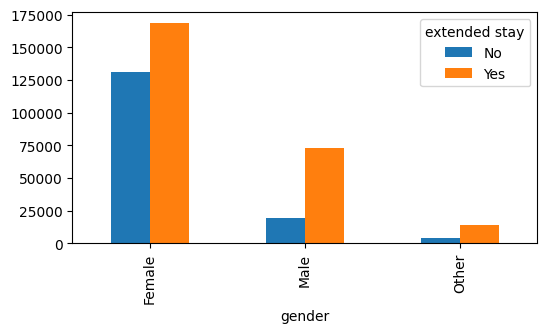

In [38]:
plot = pd.crosstab(index=data['gender'], 
                   columns=data['extended stay']).plot(kind='bar', figsize=(6,3))

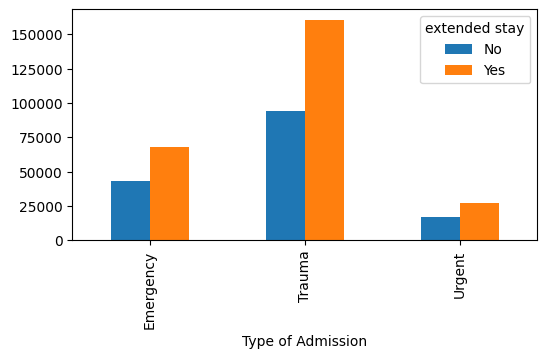

In [39]:
plot = pd.crosstab(index=data['Type of Admission'], 
                   columns=data['extended stay']).plot(kind='bar', figsize=(6,3))

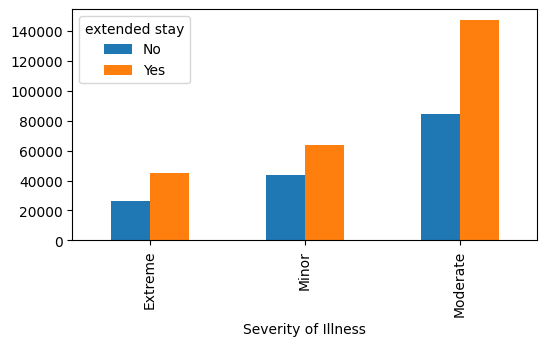

In [40]:
plot = pd.crosstab(index=data['Severity of Illness'], 
                   columns=data['extended stay']).plot(kind='bar', figsize=(6,3))

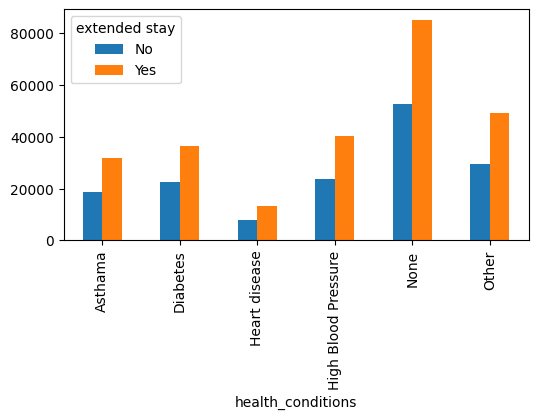

In [41]:
plot = pd.crosstab(index=data['health_conditions'], 
                   columns=data['extended stay']).plot(kind='bar', figsize=(6,3))

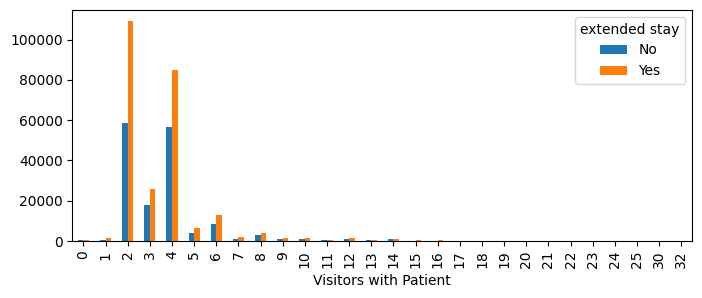

In [42]:
plot = pd.crosstab(index=data['Visitors with Patient'], 
                   columns=data['extended stay']).plot(kind='bar', figsize=(8,3))

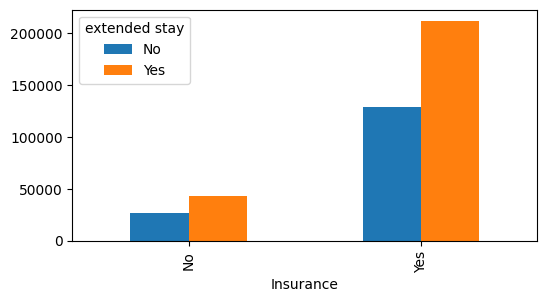

In [43]:
plot = pd.crosstab(index=data['Insurance'], 
                   columns=data['extended stay']).plot(kind='bar', figsize=(6,3))

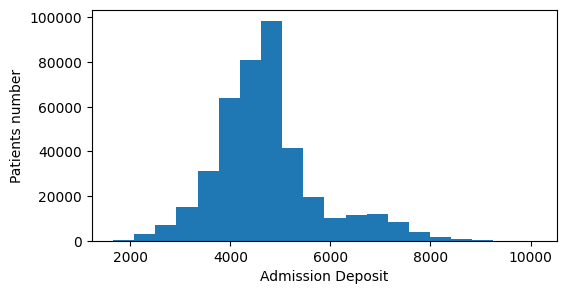

In [44]:
plt.figure(figsize=(6,3))
plt.hist(data['Admission_Deposit'], 20)
plt.xlabel('Admission Deposit')
plt.ylabel('Patients number')
plt.show()

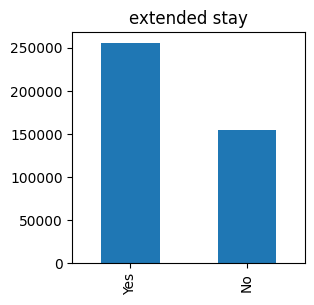

In [45]:
plot = data['extended stay'].value_counts().plot(kind='bar', title='extended stay', figsize=(3, 3))

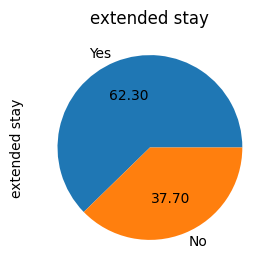

In [46]:
plot = data['extended stay'].value_counts().plot(kind='pie', autopct='%.2f', 
                                                 figsize=(3, 3),
                                                 title='extended stay')

# Feature engineering

Reemplazados los valores de la columna 'extended stay' por 0's y 1's.
Y eliminamos las columnas 'patientid' y 'Stay (in days)'

In [47]:
data['extended stay'] = data['extended stay'].apply(lambda x: 1 if x=='Yes' else 0)
data.drop(['patientid', 'Stay (in days)'], axis=1, inplace=True)

Creamos dummies sobre las columnas con datos categóricos

In [48]:
cols_dummies = ['Department', 'Ward_Facility_Code', 'doctor_name', 'Age', 
                'gender', 'Type of Admission', 'Severity of Illness', 
                'health_conditions', 'Insurance']

data = pd.concat([data, pd.get_dummies(data[cols_dummies])], axis=1)
data.drop(cols_dummies, axis=1, inplace=True)
data.head()

,Available Extra Rooms in Hospital,staff_available,Visitors with Patient,Admission_Deposit,extended stay,Department_TB & Chest disease,Department_anesthesia,Department_gynecology,Department_radiotherapy,Department_surgery,...,Severity of Illness_Minor,Severity of Illness_Moderate,health_conditions_Asthama,health_conditions_Diabetes,health_conditions_Heart disease,health_conditions_High Blood Pressure,health_conditions_None,health_conditions_Other,Insurance_No,Insurance_Yes
0,4,0,4,2966.408696,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,4,2,2,3554.835677,1,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
2,2,8,2,5624.733654,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,4,7,4,4814.149231,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
4,2,10,2,5169.269637,1,0,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0


Dada la cantidad de datos, probaremos solo usar el 20% de estos para entrenar 
los modelos y el resto para hacer testing 

In [49]:
data_x = data.loc[:, data.columns != 'extended stay']
data_y = data['extended stay']
data_x = data_x.to_numpy()
data_y = data_y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, train_size=0.2, random_state=0)

# Construcción y entrenamiento de diferentes modelos de ML

Todos los modelos se contruyeron de forma similar usando un Pipeline donde se conecta un Scaler
y un Model. 

Posteriormente se utiliza GridSearchCV para buscar hiperparámetros y entrenar el modelo 
usando Cross Validation. 

Una vez entrenado el modelo se muestra un reporte de las diferentes métricas 
y sd grafica la matriz de confusión. 

Los modelos que se utilizaron fueron los siguientes:
- MLP Classifier
- Random Forest Classifier
- Support Vector Classification
- Gradient Boosting Classifier
- Extreme Gradient Boosting Classifier

## Selección de features

In [ ]:
scaler = MinMaxScaler()
model = DecisionTreeClassifier(max_depth=8, random_state=0)
pipe = Pipeline([('scaler', scaler), ('dtc', model)])
sfs = SequentialFeatureSelector(estimator = pipe,
                                n_features_to_select = 45, 
                                direction = 'backward', 
                                cv = 3)
sfs.fit(X_train, y_train)

## MLP Classifier

In [51]:
scaler = MinMaxScaler()
model = MLPClassifier(activation='relu', max_iter=300, random_state=0)
pipe = Pipeline([('scaler', scaler), ('mlp', model)])

param_grid = {'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)]}

mlp = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
mlp.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('mlp',
                                        MLPClassifier(max_iter=300,
                                                      random_state=0))]),
             param_grid={'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)]},
             scoring='accuracy')

In [52]:
print('Train score: ',mlp.score(X_train, y_train))
print('Test score: ',mlp.score(X_test, y_test))

Train score:  0.7585243902439024
Test score:  0.7113170731707317


In [53]:
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.55      0.59    123906
           1       0.75      0.81      0.78    204094

    accuracy                           0.71    328000
   macro avg       0.69      0.68      0.68    328000
weighted avg       0.71      0.71      0.71    328000



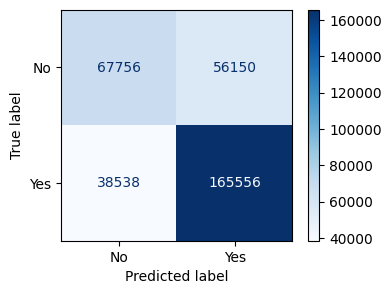

In [54]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                              display_labels = ['No', 'Yes'])
plt.rcParams["figure.figsize"] = (4,3)
disp.plot(cmap='Blues')
plt.show()

Guardamos el modelo

In [55]:
with open("./Models/MLPClassifier.pickle", "wb") as f:
    pickle.dump(mlp, f)

## Random Forest Classifier

In [56]:
scaler = MinMaxScaler()
model = RandomForestClassifier(random_state=0, n_jobs=-1)
pipe = Pipeline([('scaler', scaler), ('rfc', model)])

param_grid = {'rfc__n_estimators': [50, 100, 150], 
              'rfc__criterion': ['gini', 'entropy'], 
              'rfc__max_depth': [8, 12, 16]}
rfc = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('rfc',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=0))]),
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': [8, 12, 16],
                         'rfc__n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [57]:
print('Train score: ',rfc.score(X_train, y_train))
print('Test score: ',rfc.score(X_test, y_test))

Train score:  0.8288048780487804
Test score:  0.7346981707317073


In [58]:
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.47      0.57    123906
           1       0.74      0.89      0.81    204094

    accuracy                           0.73    328000
   macro avg       0.73      0.68      0.69    328000
weighted avg       0.73      0.73      0.72    328000



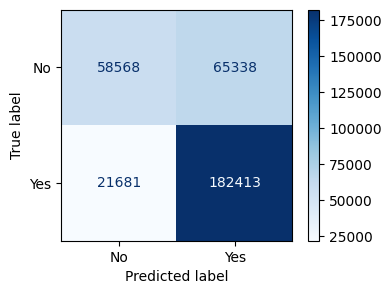

In [59]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                              display_labels = ['No', 'Yes'])
plt.rcParams["figure.figsize"] = (4,3)
disp.plot(cmap='Blues')
plt.show()

In [60]:
with open("./Models/RandomForestClassifier.pickle", "wb") as f:
    pickle.dump(rfc, f)

## Support Vector Classification

Por el tiempo computacional que requiere SVC, solo utilizamos 15000 
muestras para entrenar el modelo.

In [61]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, 
                                                        train_size=15000,
                                                        test_size=15000,
                                                        random_state=0)

scaler = MinMaxScaler()
model = SVC(random_state=0)
pipe = Pipeline([('scaler', scaler), ('svc', model)])

param_grid = {'svc__kernel': ['rbf', 'poly', 'sigmoid']}

svc = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
svc.fit(X_train_, y_train_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svc', SVC(random_state=0))]),
             param_grid={'svc__kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [62]:
print('Train score: ', svc.score(X_train_, y_train_))
print('Test score: ', svc.score(X_test_, y_test_))

Train score:  0.7079333333333333
Test score:  0.6917333333333333


In [63]:
y_pred = svc.predict(X_test_)
print(classification_report(y_test_, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.27      0.40      5592
           1       0.68      0.94      0.79      9408

    accuracy                           0.69     15000
   macro avg       0.71      0.61      0.59     15000
weighted avg       0.70      0.69      0.64     15000



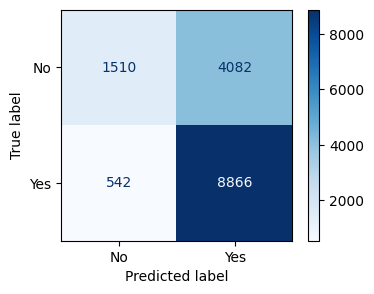

In [64]:
cm = confusion_matrix(y_test_, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                              display_labels = ['No', 'Yes'])
plt.rcParams["figure.figsize"] = (4,3)
disp.plot(cmap='Blues')
plt.show()

In [65]:
with open("./Models/SupportVectorClassifier.pickle", "wb") as f:
    pickle.dump(svc, f)

## Gradient Boosting Classifier

In [66]:
scaler = MinMaxScaler()
model = GradientBoostingClassifier(random_state=0)
pipe = Pipeline([('scaler', scaler), ('gbc', model)])

param_grid = {'gbc__n_estimators': (100, 200), 
              'gbc__max_depth': (6, 12), 
              'gbc__subsample': (0.9, 0.5)}
gbc = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
gbc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('gbc',
                                        GradientBoostingClassifier(random_state=0))]),
             param_grid={'gbc__max_depth': (6, 12),
                         'gbc__n_estimators': (100, 200),
                         'gbc__subsample': (0.9, 0.5)},
             scoring='accuracy')

In [67]:
print('Train score: ', gbc.score(X_train, y_train))
print('Test score: ', gbc.score(X_test, y_test))

Train score:  0.9824756097560976
Test score:  0.7841432926829268


In [68]:
y_pred = gbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.68      0.70    123906
           1       0.81      0.85      0.83    204094

    accuracy                           0.78    328000
   macro avg       0.77      0.76      0.77    328000
weighted avg       0.78      0.78      0.78    328000



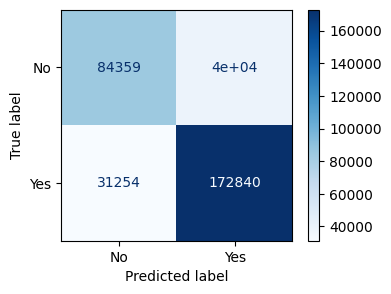

In [69]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                              display_labels = ['No', 'Yes'])
plt.rcParams["figure.figsize"] = (4,3)
disp.plot(cmap='Blues')
plt.show()

In [70]:
with open("./Models/GradientBoostingClassifier.pickle", "wb") as f:
    pickle.dump(gbc, f)

## Extreme Gradient Boosting Classifier

In [71]:
scaler = MinMaxScaler()
model = XGBClassifier(random_state=0, learning_rate=0.01, n_jobs=-1)
pipe = Pipeline([('scaler', scaler), ('xgb', model)])

param_grid = {'xgb__objective': ['binary:logistic'], 
              'xgb__n_estimators':[250,500], 
              'xgb__max_depth':[5,10,15], }

xgb = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=None...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=0, ...))]),
             param_grid={'xgb__max_depth': [5, 10, 15],
                         'xgb__n_estimators': [250, 500],
                         'xgb__objective': ['binary:logistic']},
             scoring='accuracy')

In [72]:
print('Train score: ',xgb.score(X_train, y_train))
print('Test score: ',xgb.score(X_test, y_test))

Train score:  0.8967804878048781
Test score:  0.7842865853658536


In [73]:
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70    123906
           1       0.81      0.85      0.83    204094

    accuracy                           0.78    328000
   macro avg       0.77      0.76      0.77    328000
weighted avg       0.78      0.78      0.78    328000



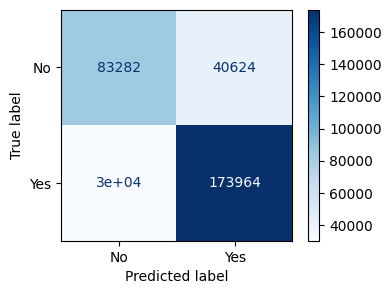

In [74]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                              display_labels = ['No', 'Yes'])
plt.rcParams["figure.figsize"] = (4,3)
disp.plot(cmap='Blues')
plt.show()

In [75]:
with open("./Models/XGBClassifier.pickle", "wb") as f:
    pickle.dump(xgb, f)

# Generar predicciones

Creamos una función que a partir de un data frame y un modelo genera predicciones, 
y otra función que guarda las predicciones en una cierta ruta.

In [113]:
def predict(model, data_test):
    
    cols_dummies = ['Department', 'Ward_Facility_Code', 'doctor_name', 'Age', 
                    'gender', 'Type of Admission', 'Severity of Illness', 
                    'health_conditions', 'Insurance']

    data_test = pd.concat([data_test, pd.get_dummies(data_test[cols_dummies])], axis=1)
    data_test.drop(cols_dummies, axis=1, inplace=True)
    data_test.drop('patientid', axis=1, inplace=True)
    data_test = data_test.to_numpy()
    pred = model.predict(data_test)
    return pred
    
def save_pred(path, pred):
    data = pd.DataFrame({'pred':pred})
    data.to_csv(path, index=False)

Cargamos los modelos gurdados y los datos de test para generar predicciones y 
guardarlas en archivos csv.

In [114]:
data_test = pd.read_csv('./Datasets/hospitalizaciones_test.csv')

for item in os.listdir('./Models'):
    with open('./Models/'+item, 'rb') as file:
        model = pickle.load(file)
    pred = predict(model, data_test)
    path = './Predictions/' + item[:-7] + '.csv'
    save_pred(path, pred)

# Comparación de los distintos modelos

Construimos un Data Frame con las métricas de Accuracy y 
Recall para los datos de entrenamiento, validación y prueba; 
para así poder compara el rendimiento de los modelos

In [118]:
acc_train = []
acc_val = []
recall_train = []
recall_val = []
models_list = []

for item in os.listdir('./Models'):
    
    with open('./Models/'+item, 'rb') as file:
        model = pickle.load(file)
        
    y_pred = model.predict(X_train)
    acc_train.append(accuracy_score(y_train, y_pred))
    recall_train.append(recall_score(y_train, y_pred))
    
    y_pred = model.predict(X_test)
    acc_val.append(accuracy_score(y_test, y_pred))
    recall_val.append(recall_score(y_test, y_pred))
    
    models_list.append(item[:-7])

In [125]:
metrics = pd.DataFrame({'Model': models_list, 
                        'Training Accuracy': acc_train, 
                        'Training Recall': recall_train, 
                        'Valdation Accuracy': acc_val, 
                        'Validation Recall': recall_val, 
                        'Testing Accuracy': [0.78, 0.71, 0.73, 0.69, 0.78], 
                        'Testing Recall': [0.81, 0.74, 0.73, 0.69, 0.81]})
metrics

,Model,Training Accuracy,Training Recall,Valdation Accuracy,Validation Recall,Testing Accuracy,Testing Recall
0,GradientBoostingClassifier,0.982476,0.990569,0.784143,0.846865,0.78,0.81
1,MLPClassifier,0.758524,0.848954,0.711317,0.811175,0.71,0.74
2,RandomForestClassifier,0.828805,0.953042,0.734698,0.893770,0.73,0.73
3,SupportVectorClassifier,0.693695,0.947761,0.688030,0.944751,0.69,0.69
4,XGBClassifier,0.896780,0.938642,0.784287,0.852372,0.78,0.81


Lo interesante es comparar el rendimiento del modelo en los datos de prueba, para eso, 
generamos los siguientes gráficos. 

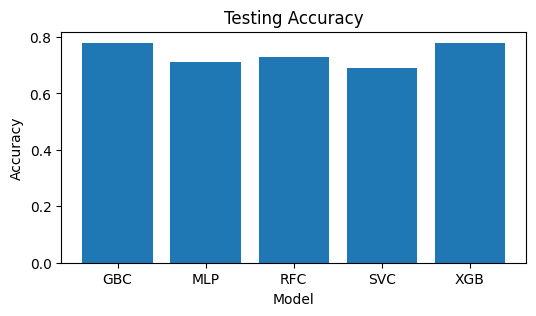

In [135]:
plt.figure(figsize=(6,3))
plt.bar(['GBC','MLP','RFC','SVC','XGB'], metrics['Testing Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Testing Accuracy')
plt.show()

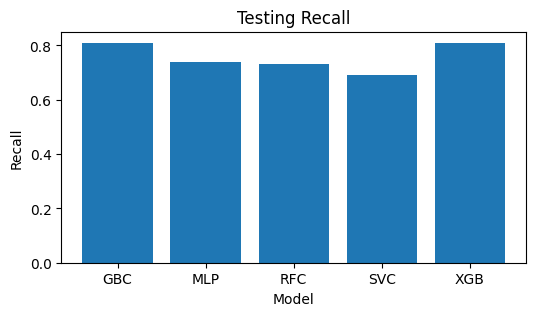

In [136]:
plt.figure(figsize=(6,3))
plt.bar(['GBC','MLP','RFC','SVC','XGB'], metrics['Testing Recall'])
plt.ylabel('Recall')
plt.xlabel('Model')
plt.title('Testing Recall')
plt.show()